In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Moves one directory up
sys.path.append(project_root)

from src.model import MiloMLP
from src.train import create_state_MLP, train_MLP, eval_MLP, pred_label
import jax
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.
from rich.progress import track

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"]
    })

tf.random.set_seed(0) 

rng = jax.random.PRNGKey(0)
device = jax.devices("cpu")[0] #Currently CPU

In [2]:
train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.squeeze(tf.cast(sample['image'], tf.float32) / 255, -1),
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.squeeze(tf.cast(sample['image'], tf.float32) / 255, -1),
    'label': sample['label'],
  }
)  # Normalize the test set.

In [3]:
lr = 1e-3
NUM_EPOCHS = 50
BATCH_SIZE = 32

In [4]:
train_ds = train_ds.repeat().shuffle(1024)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).take(2500).cache().prefetch(1)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [5]:
milo = MiloMLP(
    input_dim=(28, 28), 
    hidden_layer_dim=[(24, 20), (14, 10), (10, 1)],
    output_dim=(10, 1) 
)

milo_state = create_state_MLP(rng, milo, lr, data_size=(32, 28, 28), device=device)

del rng

In [6]:
metrics_history = {
    'loss': []
}

best_loss = np.inf; best_state = None

metrics_history = {'loss': []}

for epoch in track(range(NUM_EPOCHS), description="Training"):
    # Training loop
    for step, this_batch in enumerate(train_ds.as_numpy_iterator()):
        milo_state = train_MLP(milo_state, this_batch)

    # Evaluation loop
    loss = []
    for test_batch in test_ds.as_numpy_iterator():
        this_loss = eval_MLP(milo_state, test_batch)
        loss.append(this_loss)

    mean_loss = np.mean(loss)
    metrics_history['loss'].append(mean_loss)

    if mean_loss < best_loss:
        best_state = milo_state

Output()

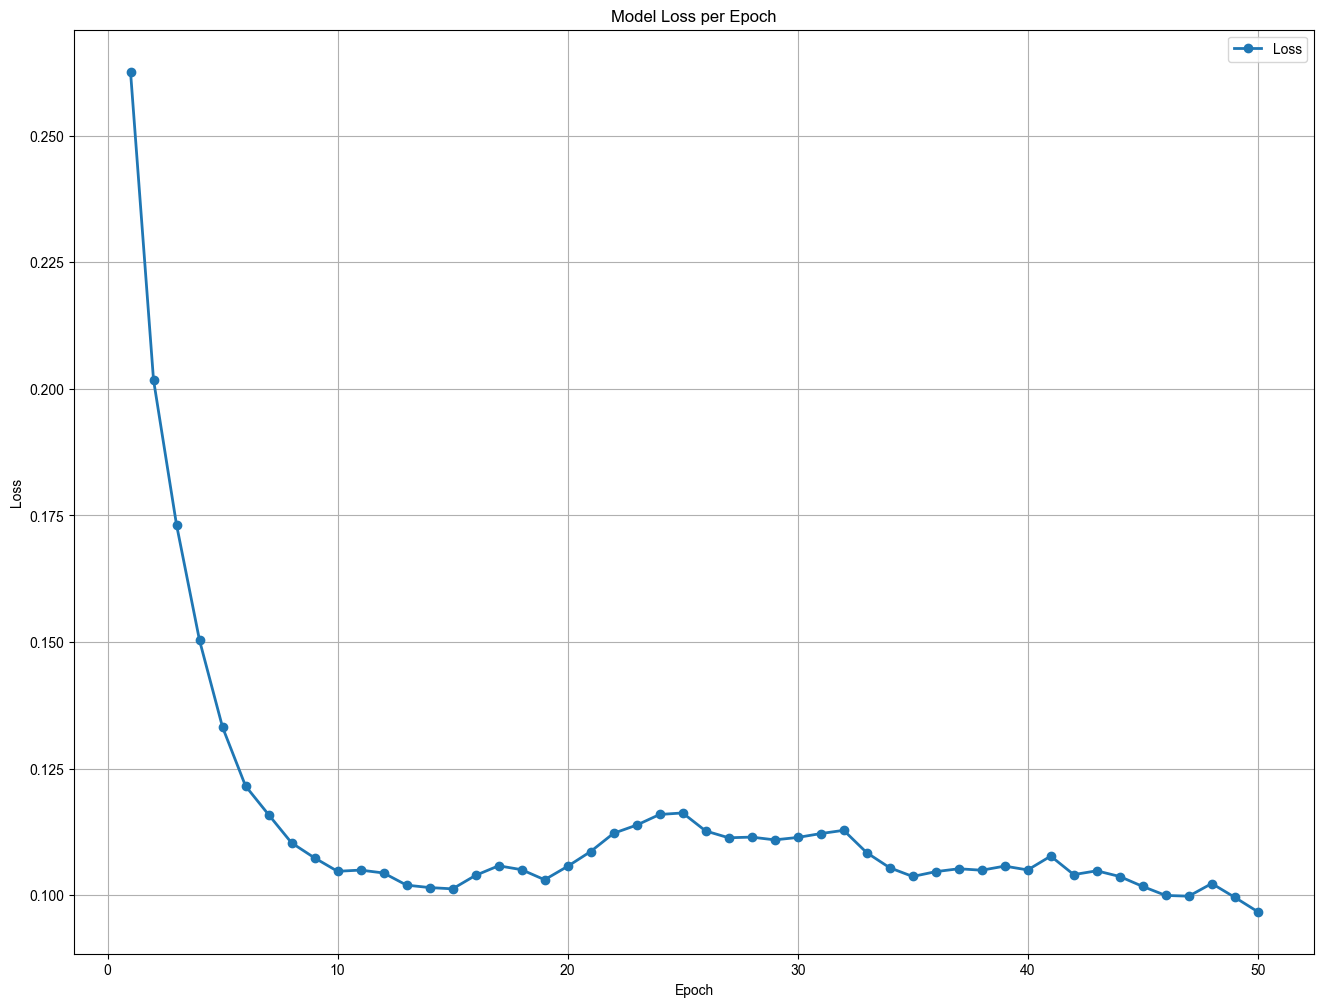

In [7]:
plt.figure(figsize=(16, 12))
epochs = range(1, len(metrics_history['loss']) + 1)
plt.plot(epochs, metrics_history['loss'], marker='o', linewidth=2, label='Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [8]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_label(milo_state, test_batch)

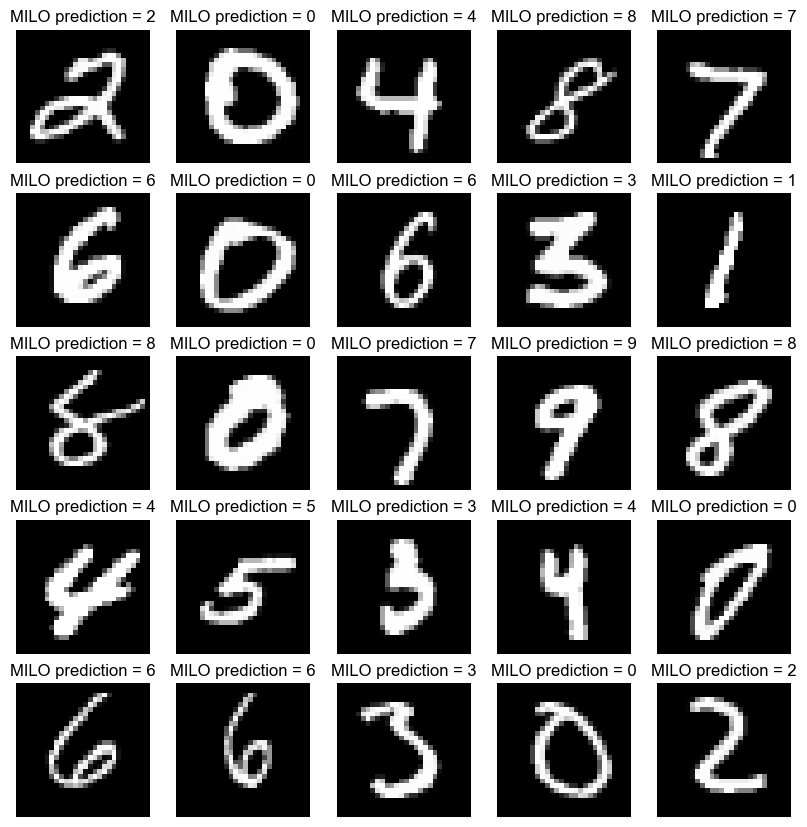

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.subplots_adjust(top=0.9)
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i], cmap='gray')
  ax.set_title(f'MILO prediction = {pred[i][0]}')
  ax.axis('off')